# Simple viewer for Grads files

In [22]:
filename = "attm102.ctl"

In [23]:
import numpy as np

In [24]:
f = open(filename, "r")
lines = f.read()
f.close

lines = lines.replace("\r", "")
lines = lines.split("\n")

In [25]:
# for line in lines:
# print(line)

## Extract the metadata

In [26]:
metadata = {}
varsKeys = []
continuation = False
for line in lines:
    if not continuation:
        try:
            key, value = line.split(None, 1)
        except:
            key = line

        key = key.strip()
        
        if key in ["DSET", "TITLE", "OPTIONS"]:
            metadata[key] = value.strip()

        elif key == "UNDEF":
            metadata[key] = float(value)

        elif key in ["XDEF", "YDEF", "ZDEF", "TDEF"]:
            fields = line.split(None)
            linlev = fields[2]
            if linlev == "LINEAR":
                if key != "TDEF":
                    metadata[key] = np.arange(float(fields[3]), int(fields[1])*float(fields[4]), float(fields[4]))
                else:
                    nfields = int(fields[1])
                    tags = []
                    for i in range(nfields):
                        tag = fields[3]+i*('+'+fields[4])
                        tags.append(tag)
                    metadata[key] = tags
            elif linlev == "LEVELS":
                levels = list(map(float, fields[3:]))
                nlevels = int(fields[1])
                if len(levels) == nlevels:
                    metadata[key] = list(map(float, fields[3:]))
                else:
                    continuation = True
            else:
                print("Unknown data grid:", linlev)

        elif key == "VARS":
            metadata[key] = int(value)

        elif key != "ENDVARS" and key != "":
            fields = line.split(None, 3)
            metadata[key] = fields[3].strip()
            varsKeys.append([key,int(fields[1])])
                
    else:  # continuation line
        fields = line.split(None)
        levels += list(map(float, fields))
        if len(levels) == nlevels:
            metadata[key] = levels
            continuation = False

if len(varsKeys) != metadata["VARS"]:
    print("There is a problem with the VARS metadata")
    print("VARS is ",metadata["VARS"],"but found",len(varsKeys),"variables")

# print(metadata)

print("Values for:")
print(varsKeys)

Values for:
[['GH', 8], ['TEMP', 8], ['U', 8], ['V', 8], ['Q', 8], ['RH', 8], ['OMEGA', 8], ['PSI', 8], ['CHI', 8], ['SP', 0], ['MSLP', 0], ['ST', 0], ['SKINT', 0], ['SWAV', 0], ['ALB', 0], ['U0', 0], ['V0', 0], ['TEMP0', 0], ['RH0', 0], ['CLC', 0], ['CLSTR', 0], ['CLTOP', 0], ['IPTOP', 0], ['LST', 0], ['SST', 0], ['SSTOM', 0], ['SSTA', 0], ['PRECLS', 0], ['PRECNV', 0], ['EVAP', 0], ['USTR', 0], ['VSTR', 0], ['TSR', 0], ['OLR', 0], ['SSR', 0], ['SLR', 0], ['SHF', 0], ['LSHF', 0], ['SSHF', 0], ['TMIN', 0], ['TMAX', 0]]


## Now find the results file and extract the data

In [27]:
grads_filename = filename[:-4]+"_"+metadata["TDEF"][0][-4:]+".grd"
print(grads_filename)

attm102_1979.grd


In [28]:
number_zeds = 0
for label, nzed in varsKeys:
    if nzed == 0:
        number_zeds +=1
    elif nzed == len(metadata["ZDEF"]):
        number_zeds += nzed
    else:
        print('Something unexpected happened')
number_values = len(metadata["XDEF"]) * len(metadata["YDEF"]) * len(metadata["TDEF"]) * number_zeds
print('number of values to read in is',number_values)

number of values to read in is 1437696


In [29]:
from scipy.io import FortranFile
data = {}
w, h = 8, 5;
values = [[0 for x in range(w)] for y in range(h)]

f = FortranFile(grads_filename, 'r', '>u4')
for label, nzed in varsKeys:
    if nzed == 0:
        values = []
        for it in range(len(metadata["TDEF"])):
            values.append(f.read_reals('>f4'))
        data[label] = values
    elif nzed == len(metadata["ZDEF"]):
        values = []
        for it in range(len(metadata["TDEF"])):
            for ized in range(nzed):
                values.append(f.read_reals('>f4'))
        values = np.stack(values, axis=0)
        data[label] = values
    else:
        print('Something unexpected happened')
f.close()
# print(data)

In [30]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd

In [31]:
result_type = "TMAX"

Need to read this very carefully:
https://ipywidgets.readthedocs.io/en/latest/user_install.html

nodejs didn't install properly on my Windows 7 machine, so I installed it from internet.

Now works on Jupyter Notebook, but not on Jupyter Lab

In [32]:
import ipywidgets as widgets

In [33]:
date_options = list(zip(metadata["TDEF"], range(0, len(metadata["TDEF"]))))
print(date_options)

[('1jan1979', 0), ('1jan1979+1mo', 1), ('1jan1979+1mo+1mo', 2)]


In [34]:
w = widgets.Dropdown(
    options=date_options,
    value=0,
    description='Choose date:',
)
display(w)

Dropdown(description='Choose date:', options=(('1jan1979', 0), ('1jan1979+1mo', 1), ('1jan1979+1mo+1mo', 2)), …

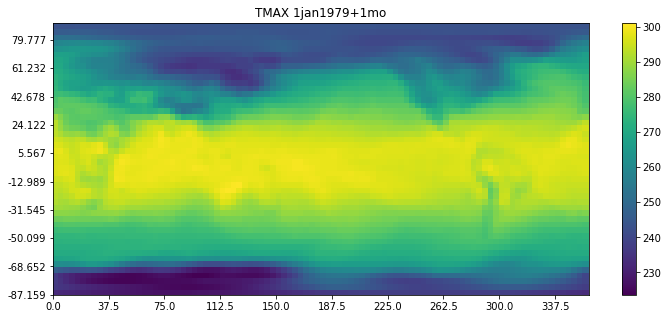

In [41]:
time_step = w.value

heat = data[result_type][time_step].reshape(len(metadata["YDEF"]), len(metadata["XDEF"]))
lenX = len(metadata["XDEF"])
lenY = len(metadata["YDEF"])

df = pd.DataFrame(heat, index= metadata["YDEF"], columns=metadata["XDEF"])

plt.figure(0,(12.,5.))
heatmap = plt.pcolor(df)
plt.title(result_type+" "+metadata["TDEF"][time_step])
plt.yticks(np.arange(0, lenY, 5), df.index[0::5])
plt.xticks(np.arange(0, lenX, 10), df.columns[0::10])
plt.colorbar(heatmap)
plt.show()